#### Contents

0. [Load data and preprocess](#Load-data-and-preprocess)
1. [Initialize VRAE object](#Initialize-VRAE-object)
2. [Fit the model onto dataset](#Fit-the-model-onto-dataset)
3. [Transform the input timeseries to encoded latent vectors](#Transform-the-input-timeseries-to-encoded-latent-vectors)
4. [Save the model to be fetched later](#Save-the-model-to-be-fetched-later)

In [39]:
import random
import torch
import numpy as np

def fix_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [40]:
fix_seed(555)

### Import required modules

In [41]:
from model.vrae import VRAE

from model.utils import *
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import trange
import tqdm

import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler


### Input parameters

In [42]:
dload = './save_model' #download directory

### utils.load_data

In [43]:
def load_gen_data(file_name, scale_type = 'Standard', cols_to_remove = None):
    """
    folder: folder where data is located
    """
    
    # define path(must be in pkl file)
    data_loc = f'./data/netis/{file_name}.pkl'    
    
    # get data
    with open(data_loc, 'rb') as f:
        df = pickle.load(f)
    
    # if needed remove columns that is not necessary
    if cols_to_remove != None:
        df = df_total.drop(cols_to_remove, axis=1)
    
    df = df.dropna()
    
    # TRAIN TEST SPLIT
    # TRAIN
    TRAIN_DF = df.query('Time < 20211103184400 or Time > 20211106084400 and label==0')
    
    # TEST(GET ONLY 정상)
    TEST_DF = df.query('Time >= 20211103184400 and Time <= 20211106084400 and label==0')

    TOTAL_DF = df.to_numpy()
    
    # REMOVE TIME & LABEL
    TRAIN_DF = TRAIN_DF.iloc[:,1:-1]
    cols = TRAIN_DF.columns
    TRAIN_DF = TRAIN_DF.to_numpy()
    TEST_DF = TEST_DF.iloc[:,1:-1].to_numpy()
    
    if scale_type == 'MinMax':
        scaler = MinMaxScaler()
    elif scale_type == 'Standard':
        scaler = StandardScaler()
    else:
        pass
    
    TRAIN_SCALED = scaler.fit(TRAIN_DF).transform(TRAIN_DF)
    TEST_SCALED = scaler.transform(TEST_DF)
    
    return TOTAL_DF, TRAIN_DF, TEST_DF, TRAIN_SCALED, TEST_SCALED, cols, scaler

### Hyper parameters

### Load data and preprocess
- `file_name` : pkl file_name
- `cols_to_remove` : generation 수행하지 않을 column 제거

In [44]:
# params
file_name = 'netis'

# load data
TOTAL_DF, TRAIN_DF, TEST_DF, TRAIN_SCALED, TEST_SCALED, cols, scaler = load_gen_data(file_name)

# shape
print(TOTAL_DF.shape)
print(TRAIN_SCALED.shape)
print(TEST_SCALED.shape)

(26002, 94)
(22363, 92)
(3627, 92)


In [7]:
class GenerationDataset(Dataset):
    def __init__(self, data, window):
        self.data = torch.Tensor(data)
        self.window = window
 
    def __len__(self):
        return len(self.data) // self.window # -1
    
    def __getitem__(self, index):
#         x = self.data[index*self.window:index*(self.window+1)]
        x = self.data[index*self.window:(index+1)*(self.window)]
        return x

In [8]:
window = 30

In [9]:
train_dataset = GenerationDataset(TRAIN_SCALED, window)
train_dataset

In [10]:
test_dataset = GenerationDataset(TEST_SCALED, window)
test_dataset

In [11]:
train_dataset[0].shape

torch.Size([30, 92])

**Fetch `sequence_length` from dataset**

In [12]:
sequence_length = train_dataset[0].shape[0]
sequence_length

30

**Fetch `number_of_features` from dataset**

This config corresponds to number of input features

In [13]:
number_of_features = train_dataset[0].shape[1]
number_of_features

92

### Parameters

In [94]:
n_epochs = 100
hidden_size = 90
# hidden_layer_depth = 2
hidden_layer_depth = 1
latent_length = 30
batch_size = 1
learning_rate = 0.0002
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=50
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

### Initialize VRAE object

VRAE inherits from `sklearn.base.BaseEstimator` and overrides `fit`, `transform` and `fit_transform` functions, similar to sklearn modules

In [95]:
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

### Fit the model onto dataset

In [96]:
loss_arr = vrae.fit(train_dataset)

#If the model has to be saved, with the learnt parameters use:
# vrae.fit(dataset, save = True)

Epoch: 0
Batch 50, loss = 60888.2305, recon_loss = 60887.9141, kl_loss = 0.3177
Batch 100, loss = 1344.4454, recon_loss = 1344.4333, kl_loss = 0.0121
Batch 150, loss = 250.0608, recon_loss = 250.0525, kl_loss = 0.0083
Batch 200, loss = 304029.8438, recon_loss = 304029.8125, kl_loss = 0.0167
Batch 250, loss = 425.3893, recon_loss = 425.3769, kl_loss = 0.0124
Batch 300, loss = 847.1760, recon_loss = 847.1647, kl_loss = 0.0113
Batch 350, loss = 740.6201, recon_loss = 740.6078, kl_loss = 0.0123
Batch 400, loss = 3139.8110, recon_loss = 3139.3525, kl_loss = 0.4585
Batch 450, loss = 210991.9375, recon_loss = 210991.1250, kl_loss = 0.8152
Batch 500, loss = 28867.4785, recon_loss = 28866.9355, kl_loss = 0.5422
Batch 550, loss = 46832.6484, recon_loss = 46830.3047, kl_loss = 2.3433
Batch 600, loss = 41230296.0000, recon_loss = 41230296.0000, kl_loss = 0.9753
Batch 650, loss = 390601807757312.0000, recon_loss = 390601807757312.0000, kl_loss = 0.2661
Batch 700, loss = 5848206785118208.0000, recon

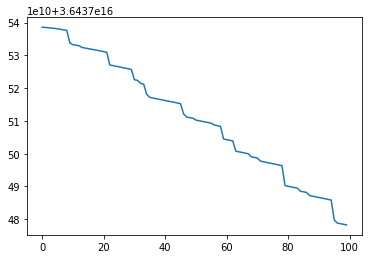

In [97]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)

### Save the model to be fetched later

In [18]:
# To save a presaved model, execute:
# vrae.save('vrae_layer1_epoch1000.pth')
# vrae.save('vrae_layer2_epoch1000.pth')

# To load a presaved model, execute:
# vrae.load('vrae_layer1_epoch1000.pth')
# vrae.load('vrae_layer2_epoch1000.pth')

In [19]:
vrae.is_fitted

True

### Transform the input timeseries to encoded latent vectors

In [20]:
z_run = vrae.transform(test_dataset)
z_run

array([[ 0.37149006,  0.19548929, -0.4733491 , ..., -0.8907772 ,
         0.32326856, -0.55709785],
       [ 0.3595212 ,  0.25622487, -0.58140874, ..., -0.7897379 ,
         0.37766486, -0.5722628 ],
       [ 0.41739964,  0.19003512, -0.5061105 , ..., -0.86193854,
         0.35663676, -0.55590016],
       ...,
       [ 0.26835892,  0.2436367 , -0.39543933, ..., -0.9192079 ,
         0.34381288, -0.5295244 ],
       [ 0.27450037,  0.2393853 , -0.37724158, ..., -0.93880385,
         0.3433256 , -0.547297  ],
       [ 0.24829076,  0.2739212 , -0.4094233 , ..., -0.877944  ,
         0.34034395, -0.5496271 ]], dtype=float32)

In [21]:
z_run.shape

(64, 30)

In [22]:
from einops import rearrange
import torch.nn as nn

In [23]:
def concat_recon(recon_output):
    
    w,b,f = recon_output.shape
    tmp = rearrange(recon_output, 'w b f -> b w f')
    output = tmp.reshape(w*b,f)

    return output

def eval_recon(recon, real, scaler = None, undo = True):
    criterion = nn.MSELoss()
    
    if undo == True:
        assert scaler != None, 'Scaler should be defined!!'
        
        # reverse scaling
        recon = scaler.inverse_transform(recon)
    
    r = recon.shape[0]
    real = real[:r,:]

    # compute loss
    eval_loss = criterion(torch.tensor(recon), torch.tensor(real))
    
    return eval_loss

def get_diff(recon, real, undo = True):
    if undo == True:
        # undo minmax scaling
        recon = inverse_minmax(recon)
    
    r = recon.shape[0]
    real = real[:r,:]
    
    return recon, real, np.abs(recon-real)

## Reconstruct

### Train

In [24]:
# train reconstruct
train_recon = vrae.reconstruct(train_dataset)
print(train_recon.shape)

(30, 704, 92)


In [25]:
train_recon = concat_recon(train_recon)
train_recon.shape

(21120, 92)

In [27]:
eval_recon(recon = train_recon, real = TRAIN_DF, scaler = scaler)

tensor(2.2022e+13, dtype=torch.float64)

In [ ]:
# eval_recon(train_recon, TRAIN_SCALED, False)

### Test

In [28]:
# test reconstruct
test_recon = vrae.reconstruct(test_dataset)
print(test_recon.shape)

(30, 64, 92)


In [29]:
test_recon = concat_recon(test_recon)
test_recon.shape

(1920, 92)

In [30]:
eval_recon(recon = test_recon, real = TEST_DF, scaler = scaler)

tensor(2.4607e+12, dtype=torch.float64)

In [ ]:
# eval_recon(test_recon, TEST_SCALED, False)

## Visualize

### Visualize Train Difference

In [31]:
train_recon, train_real, train_diff  = get_diff(train_recon, TRAIN_SCALED, False)
train_diff.shape

(21120, 92)

In [ ]:
train_recon = pd.DataFrame(train_recon, columns= cols)
train_real = pd.DataFrame(train_real, columns= cols)
train_diff = pd.DataFrame(train_diff, columns= cols)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

plt.rcParams["figure.figsize"] = (20,5)

for i in cols:
    print(f'Saving plot {i}')
    plt.plot(train_diff[i])
    plt.title(f'{i}')
    plt.savefig(f'./result/plots/train/layer2/{i}.png')
    plt.clf() # Clear the current figure

# plt.plot(train_diff[cols[random.randrange(92)]])
# plt.title(f'{cols[random.randrange(92)]}')

### Visualize Test Difference

In [ ]:
test_recon, test_real, test_diff  = get_diff(test_recon, TEST_SCALED, False)
test_diff.shape

In [ ]:
test_recon = pd.DataFrame(test_recon, columns= cols)
test_real = pd.DataFrame(test_real, columns= cols)
test_diff = pd.DataFrame(test_diff, columns= cols)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

plt.rcParams["figure.figsize"] = (20,5)

for i in cols:
    print(f'Saving plot {i}')
    plt.plot(test_diff[i])
    plt.title(f'{i}')
    plt.savefig(f'./result/plots/test/layer2/{i}.png')
    plt.clf() # Clear the current figure


# plt.plot(train_diff[cols[random.randrange(92)]])
# plt.title(f'{cols[random.randrange(92)]}')